In [10]:
import sys 
import PIL.Image as Image 
import os 
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
import warnings
import torch.nn.functional as F

sys.path.append('../utils/')
import outil
import torchvision.models as models


if not sys.warnoptions:
    warnings.simplefilter("ignore")

sys.path.append('../model')
from resnet50 import resnet50

import torchvision.models as models
import kornia.geometry as tgm
import matplotlib.pyplot as plt 
%matplotlib inline 

minSize = 480 # min dimension in the resized image
nbIter = 10000 # nb Iteration
tolerance = 0.05 # tolerance
transform = 'Homography' # coarse transformation
strideNet = 16 # make sure image size is multiple of strideNet size
MocoFeat = True ## using moco feature or not

### ImageNet normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preproc = transforms.Compose([transforms.ToTensor(), normalize,])


    

### Loading model (Moco feature or ImageNet feature)

In [11]:
if MocoFeat : 
    resnet_feature_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3']
    resNetfeat = resnet50()
    featPth = '../model/pretrained/resnet50_moco.pth'
    param = torch.load(featPth)
    state_dict = {k.replace("module.", ""): v for k, v in param['model'].items()}
    msg = 'Loading pretrained model from {}'.format(featPth)
    print (msg)
    resNetfeat.load_state_dict( state_dict )       

else : 
    resnet_feature_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3']
    resNetfeat = models.resnet50(pretrained=True)           
resnet_module_list = [getattr(resNetfeat,l) for l in resnet_feature_layers]
last_layer_idx = resnet_feature_layers.index('layer3')
resNetfeat = torch.nn.Sequential(*resnet_module_list[:last_layer_idx+1])

resNetfeat.cuda()
resNetfeat.eval()


Loading pretrained model from ../model/pretrained/resnet50_moco.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [12]:
if transform == 'Affine' :
 
    Transform = outil.Affine
    nbPoint = 3
    
else : 
    Transform = outil.Homography
    nbPoint = 4


### Loading images

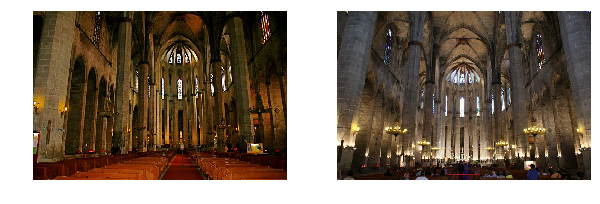

In [13]:
img1 = '../img/MegaDepth_Train_Org_2_1.jpg'
img2 = '../img/MegaDepth_Train_Org_2_2.jpg'
I1 = Image.open(img1).convert('RGB')
I2 = Image.open(img2).convert('RGB')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')

plt.imshow(I2)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(I1)

plt.show()


### Pre-processing images (multi-scale + imagenet normalization)

In [14]:
## We only compute 3 scales : 
I1Down2 = outil.resizeImg(I1, strideNet, minSize // 2)
I1Up2 = outil.resizeImg(I1, strideNet, minSize * 2)
I1 = outil.resizeImg(I1, strideNet, minSize)
I1Tensor = transforms.ToTensor()(I1).unsqueeze(0).cuda()


feat1Down2 = F.normalize(resNetfeat(preproc(I1Down2).unsqueeze(0).cuda()))
feat1 = F.normalize(resNetfeat(preproc(I1).unsqueeze(0).cuda()))
feat1Up2 = F.normalize(resNetfeat(preproc(I1Up2).unsqueeze(0).cuda()))


I2 = outil.resizeImg(I2, strideNet, minSize)
I2Tensor = transforms.ToTensor()(I2).unsqueeze(0).cuda()
feat2 = F.normalize(resNetfeat(preproc(I2).unsqueeze(0).cuda()))

### Extract matches 

In [15]:
W1Down2, H1Down2 = outil.getWHTensor(feat1Down2)
W1, H1 = outil.getWHTensor(feat1)
W1Up2, H1Up2 = outil.getWHTensor(feat1Up2)


featpMultiScale = torch.cat((feat1Down2.contiguous().view(1024, -1), feat1.contiguous().view(1024, -1), feat1Up2.contiguous().view(1024, -1)), dim=1)
WMultiScale = torch.cat((W1Down2, W1, W1Up2))
HMultiScale = torch.cat((H1Down2, H1, H1Up2))

W2, H2 = outil.getWHTensor(feat2)
        
feat2T = feat2.contiguous().view(1024, -1) 
        
        
## get mutual matching
index1, index2 = outil.mutualMatching(featpMultiScale, feat2T)
W1MutualMatch = WMultiScale[index1]
H1MutualMatch = HMultiScale[index1]

W2MutualMatch = W2[index2]
H2MutualMatch = H2[index2]


ones = torch.cuda.FloatTensor(H2MutualMatch.size(0)).fill_(1)
match2 = torch.cat((H1MutualMatch.unsqueeze(1), W1MutualMatch.unsqueeze(1), ones.unsqueeze(1)), dim=1)
match1 = torch.cat((H2MutualMatch.unsqueeze(1), W2MutualMatch.unsqueeze(1), ones.unsqueeze(1)), dim=1)

### RANSAC 

In [16]:
## if very few matches, it is probably not a good pair
if len(match1) < nbPoint : 
    print ('not a good pair...')    
bestParam, bestInlier, match1Inlier, match2Inlier = outil.RANSAC(nbIter, match1, match2, tolerance, nbPoint, Transform)


### return pair coarsely aligned

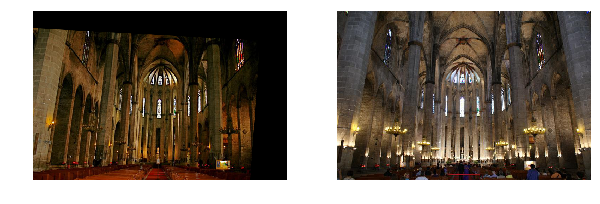

In [17]:
## We keep the pair only we have enough inliers
if len(match1Inlier) > 50 : 
                
    if transform == 'Affine':
        grid = F.affine_grid(torch.from_numpy(bestParam[:2].astype(np.float32)).unsqueeze(0).cuda(), IpTensor.size()) # theta should be of size N×2×3
    else : 

        warper = tgm.HomographyWarper(I1Tensor.size()[2],  I1Tensor.size()[3])
        grid =  warper.warp_grid(torch.from_numpy(bestParam.astype(np.float32)).unsqueeze(0).cuda())


    I2Sample = F.grid_sample(I2Tensor.clone(), grid)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')

    plt.imshow(transforms.ToPILImage()(I2Sample.squeeze().cpu()))
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(I1)

    plt.show()